In [1]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from tensorflow.keras import optimizers, layers, models
from matplotlib import pyplot as plt

## Data Prep

In [117]:
image_dir = "images/lattice_points"
train_files = [[], []]

for file in os.listdir(os.path.join(image_dir, "no")):
    if file.endswith(".jpg"):
        train_files[0].append(os.path.join(image_dir, "no", file))

for file in os.listdir(os.path.join(image_dir, "yes")):
    if file.endswith(".jpg"):
        train_files[1].append(os.path.join(image_dir, "yes", file))

In [118]:
all_images = []
all_labels = []

for i in range(2):
    for file in train_files[i]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
        img = cv2.Canny(img, 0, 255)
        
        img = img.astype(np.float32) / 255.0
        
        all_images.append(img)
        
        label = [0, 0]
        label[i] = 1
        all_labels.append(label)

all_images = np.array(all_images)[..., np.newaxis]
all_labels = np.array(all_labels)

In [119]:
print(all_images.shape, all_labels.shape)
print(all_images.max())
print(all_labels[0])

(848, 21, 21, 1) (848, 2)
1.0
[1 0]


[0 1]


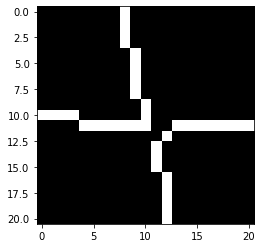

In [120]:
plt.figure()
plt.imshow(all_images[-1][:, :, 0], cmap="gray")
print(all_labels[-1])

In [121]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

train_indices = random.sample(range(len(all_images)), int(len(all_images) * 0.8))

for i in range(len(all_images)):
    if i in train_indices:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])
    else:
        valid_images.append(all_images[i])
        valid_labels.append(all_labels[i])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [122]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=4,
    height_shift_range=4)

## Initialize Network

In [102]:
model = models.Sequential()
model.add(layers.Dense(441, input_shape=(21, 21, 1)))

for i in range(2):
    for j in [3, 2, 1]:
        model.add(layers.Conv2D(16, j, activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    
model.add(layers.Dense(128, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizers.RMSprop(lr=1e-3), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [103]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 21, 21, 441)       882       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 19, 19, 16)        63520     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 18, 16)        1040      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 18, 18, 16)        272       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 9, 9, 16)          64        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 16)         

In [104]:
def generate_data(train_images, train_labels, batch_size):
    gen = datagen.flow(train_images, train_labels, batch_size=batch_size)
    while True:
        x, y = gen.next()
        yield x, y

In [123]:
batch_size = train_images.shape[0]
epochs = 200

history = model.fit_generator(generate_data(train_images, train_labels, batch_size=batch_size),
                              steps_per_epoch=train_images.shape[0] / batch_size,
                              epochs=epochs, validation_data = (valid_images, valid_labels))

W0204 09:37:33.665968 4370562496 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 1.0 steps, validate on 170 samples
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.0910 - categorical_accuracy: 0.9661 - val_loss: 0.1330 - val_categorical_accuracy: 0.9588
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.0872 - categorical_accuracy: 0.9720 - val_loss: 0.1277 - val_categorical_accuracy: 0.9647
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 0.1082 - categorical_accuracy: 0.9661 - val_loss: 0.1551 - val_categorical_accuracy: 0.9588
Epoch 4/200
1/1 [==============================] - 3s 3s/step - loss: 0.0925 - categorical_accuracy: 0.9690 - val_loss: 0.1676 - val_categorical_accuracy: 0.9588
Epoch 5/200
1/1 [==============================] - 2s 2s/step - loss: 0.1118 - categorical_accuracy: 0.9631 - val_loss: 0.1480 - val_categorical_accuracy: 0.9647
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.1160 - categorical_accuracy: 0.9558 - val_loss: 0.1723 - val_categorical_

1/1 [==============================] - 2s 2s/step - loss: 0.0869 - categorical_accuracy: 0.9720 - val_loss: 0.1441 - val_categorical_accuracy: 0.9765
Epoch 52/200
1/1 [==============================] - 2s 2s/step - loss: 0.0731 - categorical_accuracy: 0.9749 - val_loss: 0.1279 - val_categorical_accuracy: 0.9706
Epoch 53/200
1/1 [==============================] - 2s 2s/step - loss: 0.0928 - categorical_accuracy: 0.9646 - val_loss: 0.1174 - val_categorical_accuracy: 0.9765
Epoch 54/200
1/1 [==============================] - 2s 2s/step - loss: 0.1096 - categorical_accuracy: 0.9676 - val_loss: 0.1214 - val_categorical_accuracy: 0.9824
Epoch 55/200
1/1 [==============================] - 2s 2s/step - loss: 0.0932 - categorical_accuracy: 0.9735 - val_loss: 0.1390 - val_categorical_accuracy: 0.9765
Epoch 56/200
1/1 [==============================] - 2s 2s/step - loss: 0.0971 - categorical_accuracy: 0.9676 - val_loss: 0.1538 - val_categorical_accuracy: 0.9647
Epoch 57/200
1/1 [=================

Epoch 102/200
1/1 [==============================] - 2s 2s/step - loss: 0.0995 - categorical_accuracy: 0.9602 - val_loss: 0.1208 - val_categorical_accuracy: 0.9824
Epoch 103/200
1/1 [==============================] - 2s 2s/step - loss: 0.0864 - categorical_accuracy: 0.9705 - val_loss: 0.1231 - val_categorical_accuracy: 0.9824
Epoch 104/200
1/1 [==============================] - 2s 2s/step - loss: 0.0934 - categorical_accuracy: 0.9676 - val_loss: 0.1332 - val_categorical_accuracy: 0.9765
Epoch 105/200
1/1 [==============================] - 2s 2s/step - loss: 0.1014 - categorical_accuracy: 0.9676 - val_loss: 0.1204 - val_categorical_accuracy: 0.9882
Epoch 106/200
1/1 [==============================] - 2s 2s/step - loss: 0.0706 - categorical_accuracy: 0.9735 - val_loss: 0.1364 - val_categorical_accuracy: 0.9824
Epoch 107/200
1/1 [==============================] - 2s 2s/step - loss: 0.1004 - categorical_accuracy: 0.9720 - val_loss: 0.1270 - val_categorical_accuracy: 0.9765
Epoch 108/200
1/

Epoch 152/200
1/1 [==============================] - 2s 2s/step - loss: 0.1227 - categorical_accuracy: 0.9587 - val_loss: 0.1310 - val_categorical_accuracy: 0.9765
Epoch 153/200
1/1 [==============================] - 2s 2s/step - loss: 0.0890 - categorical_accuracy: 0.9617 - val_loss: 0.1226 - val_categorical_accuracy: 0.9824
Epoch 154/200
1/1 [==============================] - 2s 2s/step - loss: 0.0860 - categorical_accuracy: 0.9661 - val_loss: 0.1219 - val_categorical_accuracy: 0.9765
Epoch 155/200
1/1 [==============================] - 2s 2s/step - loss: 0.0911 - categorical_accuracy: 0.9690 - val_loss: 0.1324 - val_categorical_accuracy: 0.9765
Epoch 156/200
1/1 [==============================] - 2s 2s/step - loss: 0.0912 - categorical_accuracy: 0.9676 - val_loss: 0.1337 - val_categorical_accuracy: 0.9706
Epoch 157/200
1/1 [==============================] - 2s 2s/step - loss: 0.0850 - categorical_accuracy: 0.9676 - val_loss: 0.1369 - val_categorical_accuracy: 0.9706
Epoch 158/200
1/

In [124]:
model_json = model.to_json()
with open("lattice_points_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lattice_points_model.h5")